In [1]:
%pylab inline

import pymc3 as pm
import numpy as np

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
w0 = np.array([.5, .5]) 

mu0 = np.array([0., 5.]) 
sd0 = np.array([1., 1.])

In [9]:
pm.NormalMixture.dist(w=w0, mu=mu0, sd=sd0).random(size=10)

array([-0.58585392, -1.61177315,  3.69462463, -0.08939876,  4.91517677,
       -0.03070208,  4.32244873,  2.22682981, -0.42773773,  3.58894173])

In [10]:
pm.Normal.dist(mu=mu0, sd=sd0, shape=2).random(size=10)

array([[-0.86988019,  4.61685761],
       [ 1.04941005,  5.77890685],
       [ 1.06199275,  5.44112334],
       [ 1.40067835,  4.9110978 ],
       [ 1.33756258,  5.47791718],
       [ 0.78723046,  5.53804174],
       [-0.02588907,  4.46892448],
       [ 0.17191092,  4.98682427],
       [ 1.07048939,  3.88019864],
       [ 1.75766283,  4.08779415]])

In [11]:
import theano.tensor as tt

class Ordered(pm.distributions.transforms.ElemwiseTransform):
    name = "ordered"

    def forward(self, x):
        out = tt.zeros(x.shape)
        out = tt.inc_subtensor(out[0], x[0])
        out = tt.inc_subtensor(out[1:], tt.log(x[1:] - x[:-1]))
        return out
    
    def forward_val(self, x, point=None):
        x, = pm.distributions.distribution.draw_values([x], point=point)
        return self.forward(x)

    def backward(self, y):
        out = tt.zeros(y.shape)
        out = tt.inc_subtensor(out[0], y[0])
        out = tt.inc_subtensor(out[1:], tt.exp(y[1:]))
        return tt.cumsum(out)

    def jacobian_det(self, y):
        return tt.sum(y[1:])

In [12]:
with pm.Model() as mixmodel:
    mu0 = pm.Normal('mu', 0., 10., shape=2,
                    testval=[0, 5.])
    pm.NormalMixture('m', w=w0, mu=mu0, sd=sd0, testval=0.)

from tempfile import mkdtemp
test_folder = mkdtemp(prefix='SMC_TEST')
mtrace = pm.smc.sample_smc(samples=1000,
                           n_chains=40,
                           n_jobs=1,
                           stage=0, 
                           model=mixmodel, 
                           homepath=test_folder,
                           progressbar=False)

/home/laoj/Documents/Github/pymc3/pymc3/step_methods/smc.py:491: UserWarning: Warning: SMC is an experimental step method, and not yet recommended for use in PyMC3!
  warnings.warn(EXPERIMENTAL_WARNING)
Argument `step` is None. Auto-initialising step object using given/default parameters.
INFO:pymc3:Argument `step` is None. Auto-initialising step object using given/default parameters.
/home/laoj/Documents/Github/pymc3/pymc3/step_methods/smc.py:118: UserWarning: Warning: SMC is an experimental step method, and not yet recommended for use in PyMC3!
  warnings.warn(EXPERIMENTAL_WARNING)
Adding model likelihood to RVs!
INFO:pymc3:Adding model likelihood to RVs!
Init new trace!
INFO:pymc3:Init new trace!
Sample initial stage: ...
INFO:pymc3:Sample initial stage: ...
Beta: 0.000000 Stage: 0
INFO:pymc3:Beta: 0.000000 Stage: 0
Initializing chain traces ...
INFO:pymc3:Initializing chain traces ...
Sampling ...
INFO:pymc3:Sampling ...
Beta: 0.140625 Stage: 1
INFO:pymc3:Beta: 0.140625 Stage: 1
In

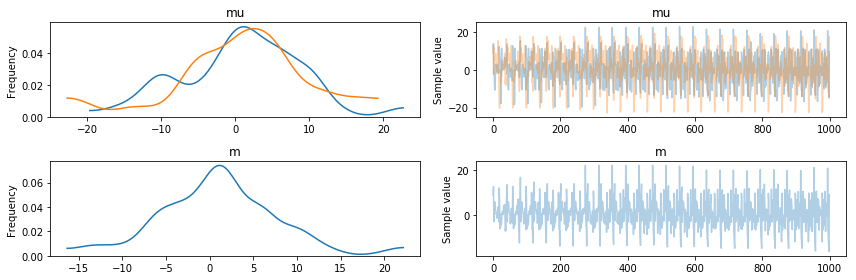

In [13]:
pm.traceplot(mtrace);

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [m]
INFO:pymc3:NUTS: [m]
100%|██████████| 1500/1500 [00:00<00:00, 2385.04it/s]
The acceptance probability does not match the target. It is 0.9289948799333033, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.


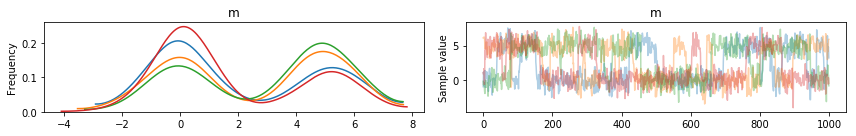

In [14]:
with pm.Model():
    pm.NormalMixture('m', 
        mu=np.array([0., 5.]), 
        w=np.array([.5, .5]), 
        sd=np.array([1., 1.]))
    trace = pm.sample(1000)
pm.traceplot(trace);